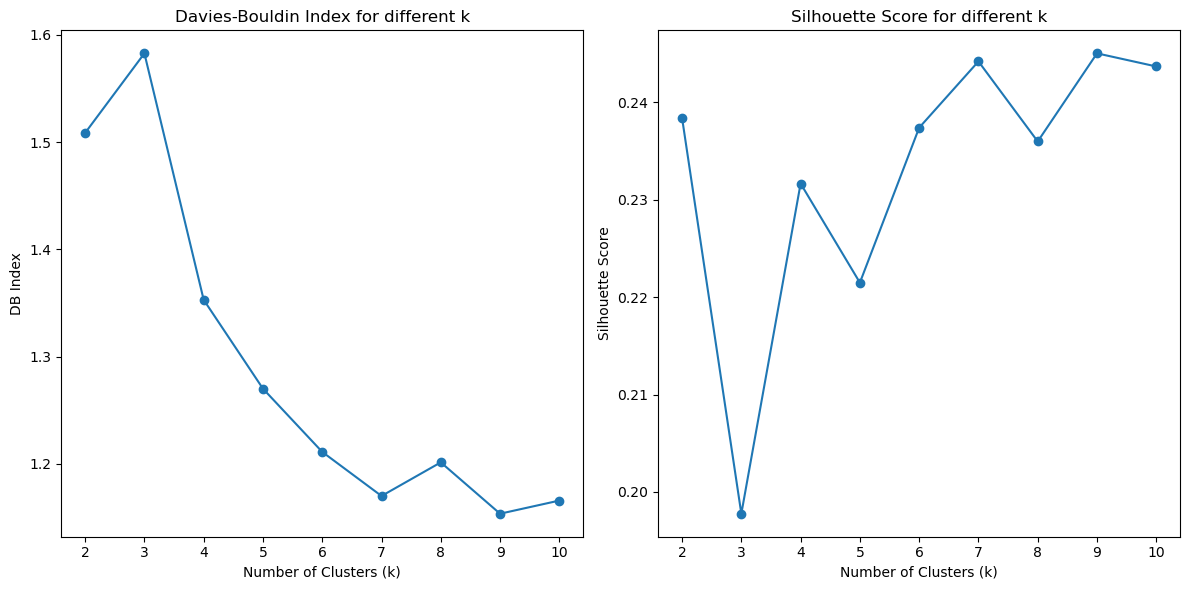

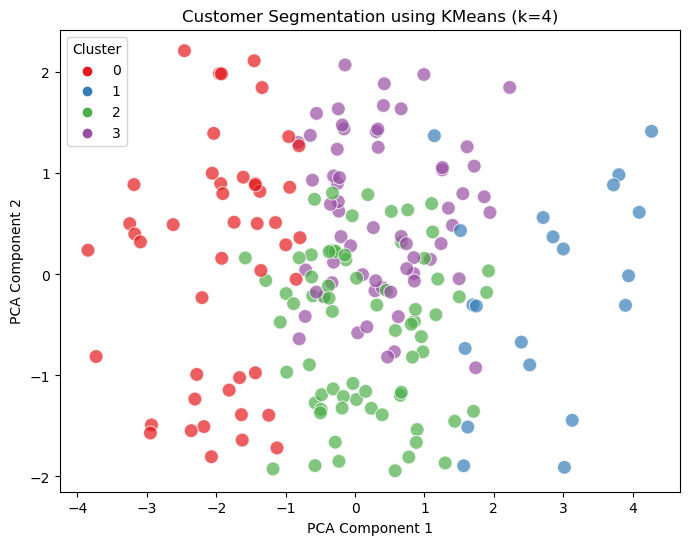

Final DB Index for k=4: 1.35299345470687
   Cluster  avg_total_spent  avg_total_transactions  avg_recency  \
0        0         8.086957                8.086957    80.086957   
1        1         2.050000                2.050000   264.800000   
2        2         4.563380                4.563380    93.859155   
3        3         4.241935                4.241935    82.274194   

   avg_signup_age  
0      615.826087  
1      578.150000  
2      509.169014  
3      564.951613  


In [8]:
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak")
os.environ["OMP_NUM_THREADS"] = "1"

customers_df = pd.read_csv("./data/Customers.csv")
transactions_df = pd.read_csv("./data/Transactions.csv")

customers_df['Region'] = customers_df['Region'].astype('category').cat.codes
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['SignupAge'] = (pd.to_datetime('today') - customers_df['SignupDate']).dt.days

transaction_summary = transactions_df.groupby('CustomerID').agg(
    total_spent=('TransactionID', 'count'),
    total_transactions=('TransactionID', 'size'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days)
).reset_index()

merged_df = customers_df.merge(transaction_summary, on='CustomerID')

X = merged_df[['Region', 'SignupAge', 'total_spent', 'total_transactions', 'recency']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

db_index_values = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    db_index_values.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_index_values, marker='o', label='Davies-Bouldin Index')
plt.title("Davies-Bouldin Index for different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("DB Index")

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', label='Silhouette Score')
plt.title("Silhouette Score for different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)

merged_df['Cluster'] = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=merged_df['Cluster'], palette='Set1', s=100, alpha=0.7)
plt.title(f"Customer Segmentation using KMeans (k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

db_index_final = davies_bouldin_score(X_scaled, kmeans.labels_)
print(f"Final DB Index for k={best_k}: {db_index_final}")

cluster_summary = merged_df.groupby('Cluster').agg(
    avg_total_spent=('total_spent', 'mean'),
    avg_total_transactions=('total_transactions', 'mean'),
    avg_recency=('recency', 'mean'),
    avg_signup_age=('SignupAge', 'mean')
).reset_index()

print(cluster_summary)
